# Mutliple multiplications, multiple layers - PCA

I'm going to focus now more on input data and activations as opposed to parameters.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1922977544
set_all_seeds(seed)
print(seed)

2024545178


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


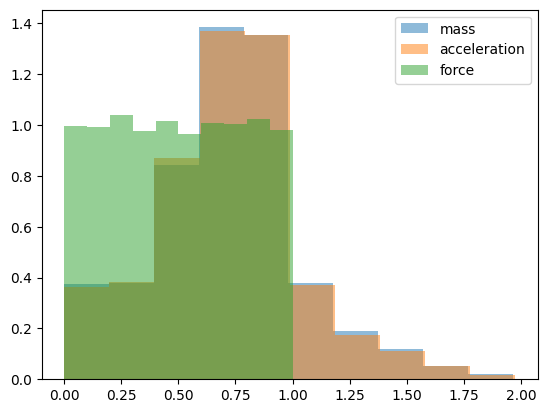

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

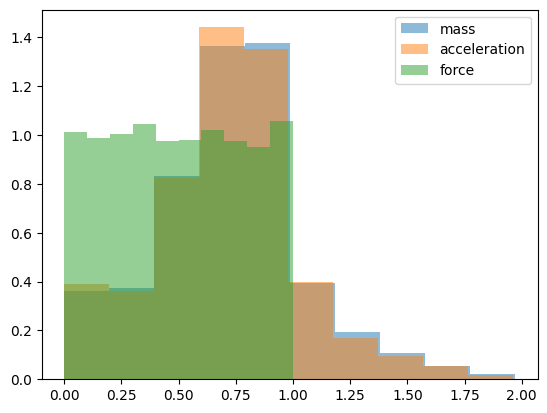

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 4000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

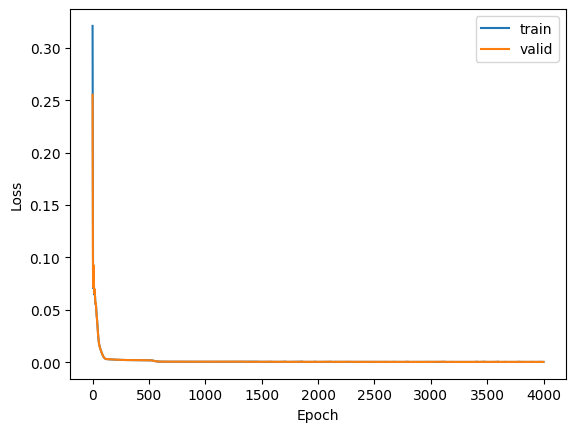

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0002)

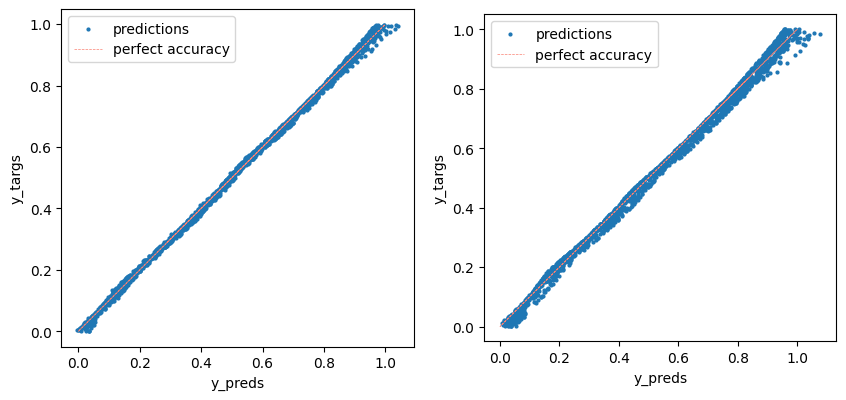

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
inputs = torch.cat((get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B")))
inputs.shape

torch.Size([20000, 4])

In [17]:
ios = capture_intermediate_outputs(model, inputs)

In [18]:
acts = ios["layers.0.act"]
acts.shape

torch.Size([20000, 16])

In [19]:
def get_pcs(data):
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances

In [20]:
pcs, vs = get_pcs(acts)

In [21]:
cA = torch.matmul(pcs, acts[:10000].T).T
cB = torch.matmul(pcs, acts[10000:].T).T
cA.shape, cB.shape

(torch.Size([10000, 16]), torch.Size([10000, 16]))

Plot each of the first $n$ principal axes against each other:

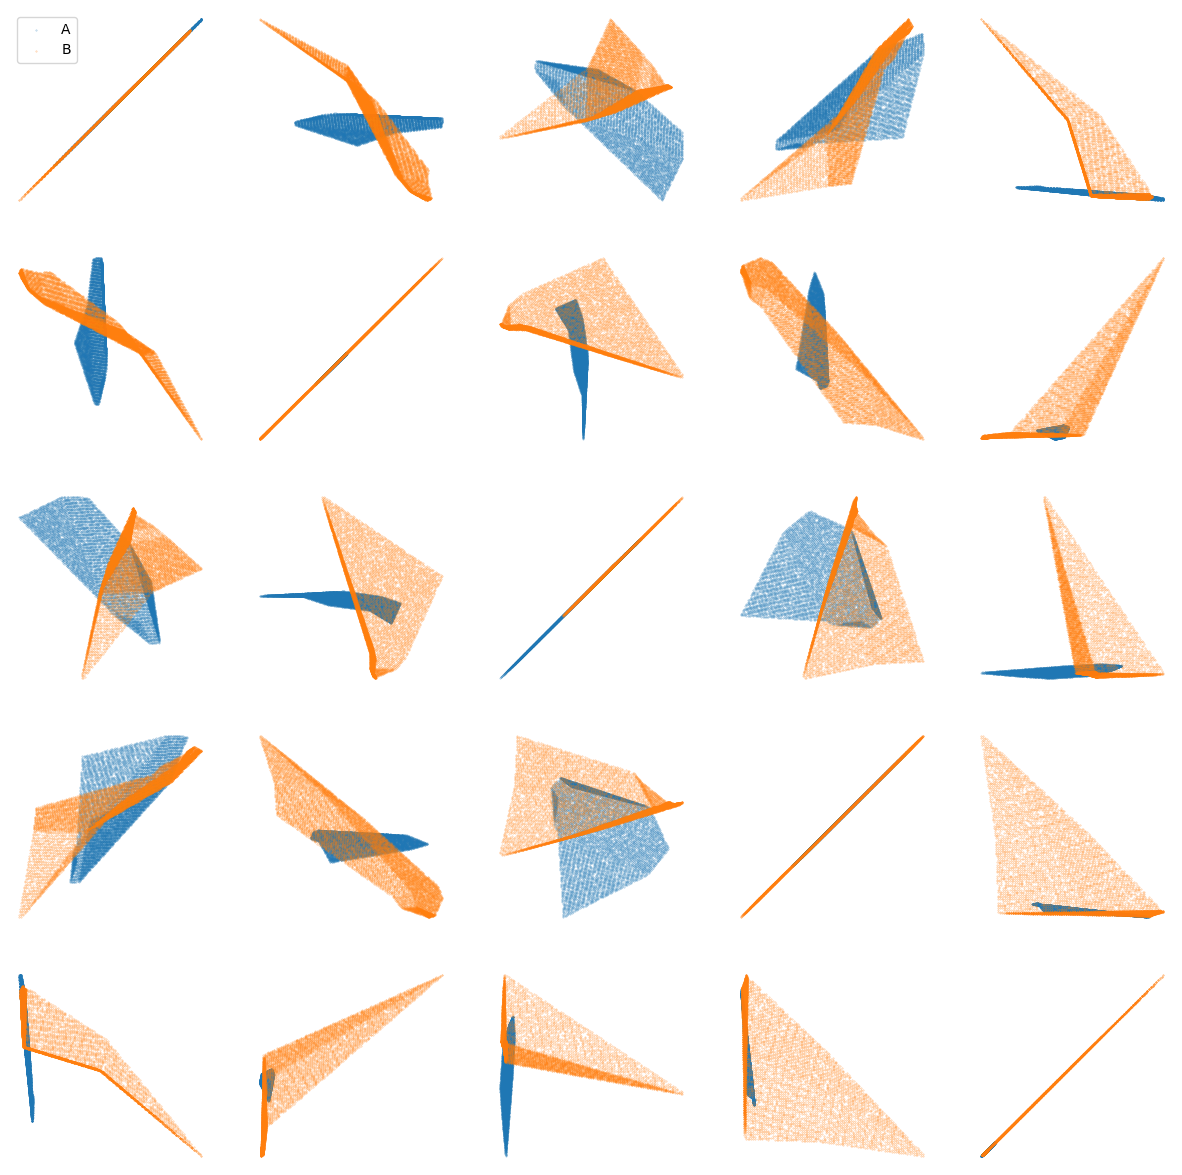

In [22]:
n = 5

fig, axes = plt.subplots(n, n, figsize=(15, 15))

mask = np.random.rand(len(acts) // 2) < 0.8

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.scatter(cA[mask, i], cA[mask, j], alpha=0.5, label="A", s=0.1)
        ax.scatter(cB[mask, i], cB[mask, j], alpha=0.5, label="B", s=0.1)
        ax.axis("off")

_ = axes[0, 0].legend()

Some things to note here:
- these are pretty
- there's redundancy here as the lower triangle is a mirror image of the upper triangle
- the diagonal is not that useful as they're essentially 1D plots
- STILL, they're pretty

Some more useful things to note:
- It's nice to see the unit square input structure propagating through to this layer - we're looking at different projections of it and you can start to make out the structure
- There are little folds at the corners, presumably from the ReLU activations
- I wonder if I should use the heatmaps here too 🤔 might get too busy
- There is separation but also overlap - we'd expect this as there is degeneracy at $(0.5,0.5,0.5,0.5)$ input
- Importantly, I can see some dimensions in which there is large variance in one of the tasks and small variance in the others - suggesting some independence. Would be good to think about a form of PCA that produces components which produce low variance in one variable and high in another...
- I'd like to move from this graphical representation to something more quantifiable though. I can think of ways into this problem with the principal components.

I'm going to try PACMAP just for laughs (although the dimensions are somewhat less meaningful):

In [23]:
import pacmap

embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)

# fit the data (The index of transformed data corresponds to the index of the original data)
acts_transformed = embedding.fit_transform(acts.numpy(), init="pca")

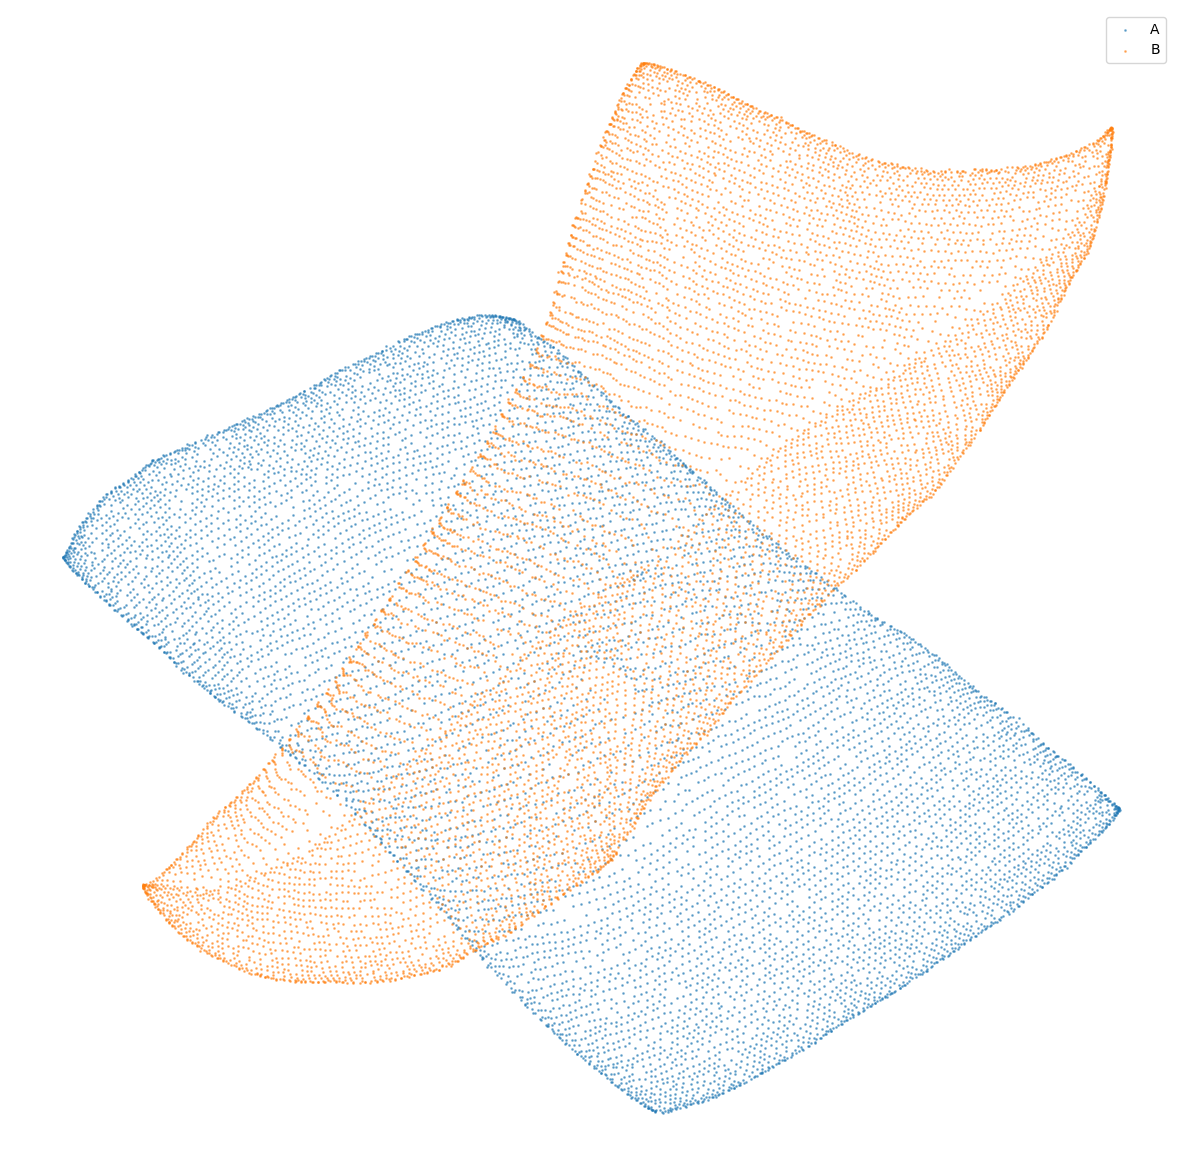

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

mask = np.random.rand(len(acts) // 2) < 0.9

ax.scatter(*acts_transformed[:10000][mask].T, alpha=0.5, label="A", s=1)
ax.scatter(*acts_transformed[10000:][mask].T, alpha=0.5, label="B", s=1)
ax.axis("off")

_ = ax.legend()

Hehe even more pretty 😍

But enough with the distracting plots, time to quantify this stuff (if I can).

## Let's quantify

So, concretely, I'm aiming to understand the extent to which variation in one set of inputs to the network is independently treated from variation in another set of inputs. The hypothesis here is that each task is roughly linearly separable in the intermediate activations i.e. has linear components which vary very little in response to changes in the other task's inputs.

I'd like to find components in the activations that simultaneously explain a large amount of variance in task A but a small amount of variance in task B.

Ideas:
1. Simply looking at the lowest variance PCA components for task A and calculating their angle with the highest variance PCA components for task B
2. I could modify the PCA algorithm somehow to bring in this constraint
1. I could optimise some matrix of linear components that was constrained to form an orthonormal basis also with a loss function that weighted the variance of each task separately. Gradient descent kind of thing.

I think I'll start with 1 because it seems the most straightforward. After that, I think potentially 3 because I'd need to brush up on my PCA algorithm basics for option 2 and option 3 might offer more control.

### Comparing PCA components

In [25]:
pcsA, vsA = get_pcs(acts[:10000])
pcsB, vsB = get_pcs(acts[10000:])

In [26]:
pcsA.shape, pcsB.shape

(torch.Size([16, 16]), torch.Size([16, 16]))

In [27]:
vsA

tensor([2.4441e-01, 1.1304e-01, 6.5148e-03, 6.6997e-04, 1.4690e-04, 7.1566e-06,
        2.3767e-07, 1.0983e-15, 5.1668e-16, 2.9909e-16, 1.9619e-16, 1.3185e-20,
        2.9683e-23, 8.9840e-32, 4.6492e-38, 4.3782e-39])

Need to be very careful that I have these dimensions right...

In [28]:
sims = torch.matmul(pcsA.T, pcsB)  # I'm pretty sure this is correct
sims = sims.numpy()

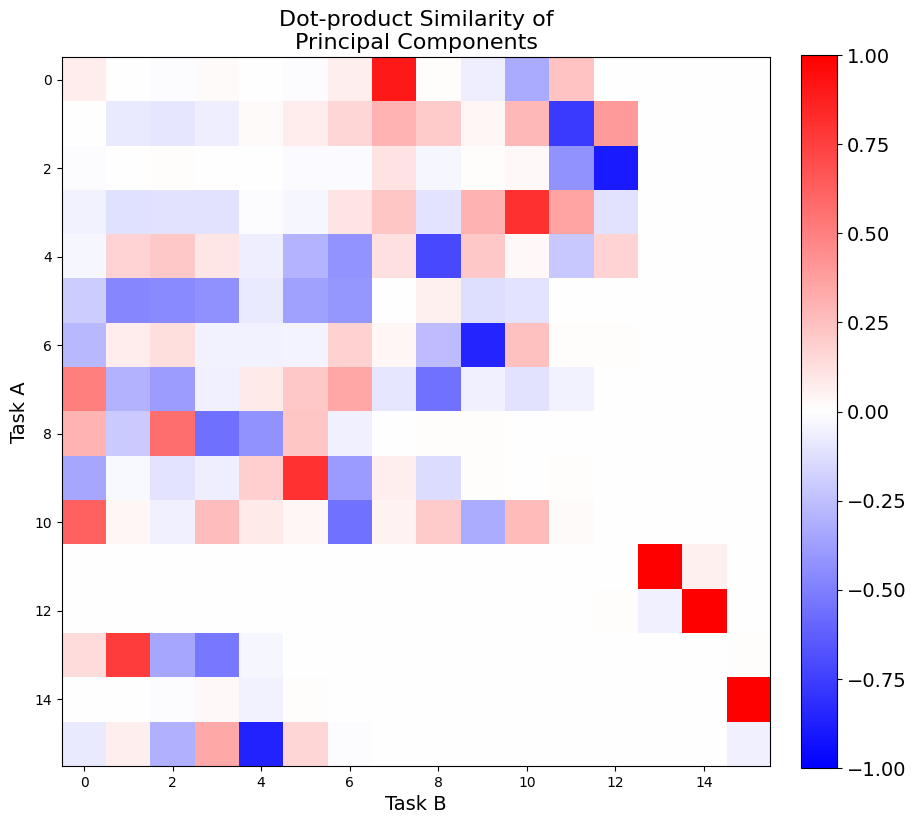

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)

ax.set_title("Dot-product Similarity of\nPrincipal Components", fontsize=16)
ax.set_xlabel("Task B", fontsize=14)
_ = ax.set_ylabel("Task A", fontsize=14)

Looking at the variance across each separate principal component is also useful:

And now looking at the variance across the principal components of Task B in the data for Task A, we see fairly low variance all around:

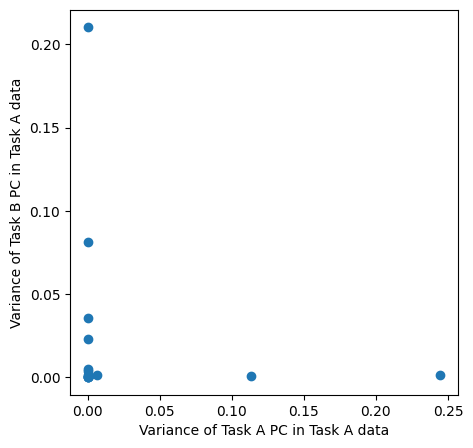

In [39]:
varAA = [torch.var((pcsA[:, i] * acts[:10000]).sum(-1)) for i in range(16)]
varBA = [torch.var((pcsB[:, i] * acts[:10000]).sum(-1)) for i in range(16)]

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(varAA, varBA)
ax.set_xlabel("Variance of Task A PC in Task A data")
_ = ax.set_ylabel("Variance of Task B PC in Task A data")

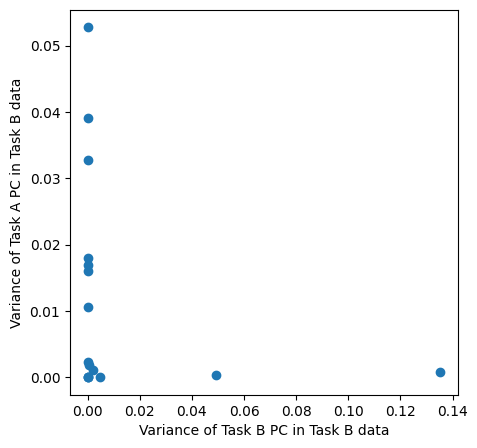

In [40]:
varBB = [torch.var((pcsB[:, i] * acts[10000:]).sum(-1)) for i in range(16)]
varAB = [torch.var((pcsA[:, i] * acts[10000:]).sum(-1)) for i in range(16)]

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(varBB, varAB)
ax.set_xlabel("Variance of Task B PC in Task B data")
_ = ax.set_ylabel("Variance of Task A PC in Task B data")

Some nice linear separation here.

TBC